

## 🧭 **Refined Plan – Problem Statement 6**

> “How do household income, parental education, and employment status relate to student enrolment and dropout rates?”

---

### **🎯 Core Idea**

We’ll build a **district-level dataset** that links:

* **Education outcomes** (from UDISE enrolment data)
* **Socioeconomic background** (from NFHS-5: income, education, employment)
* **Rural/urban composition** (from UDISE Profile)

Then analyze statistical correlations, fit regression & ML models, and visualize patterns that explain how socioeconomic factors shape school outcomes.

---

## ⚙️ Phase 1 — Dataset Selection & Purpose

| Dataset                     | Use                                                                                    | Key Variables                                    |
| --------------------------- | -------------------------------------------------------------------------------------- | ------------------------------------------------ |
| **enr1 (2023–24, 2024–25)** | To compute total enrolment and dropout rates per school → aggregated to district level | `pseudocode`, class-wise enrolments (c1–c12_b/g) |
| **prof1**                   | To map schools to **district** and **rural/urban** category                            | `district`, `rural_urban`                        |
| **NFHS-5**                  | To extract district-level socioeconomic indicators                                     | Income, parental education, employment           |

🧩 Merge Plan:
`enr1 + prof1` → District-level aggregated education outcomes
↓
Merge with `NFHS-5` on cleaned `district` names
→ Combined socio-educational dataset

---

## 🧮 Phase 2 — Feature Engineering

### **1️⃣ Compute UDISE Indicators**

| Indicator              | Formula                                 | Level    |
| ---------------------- | --------------------------------------- | -------- |
| `total_enrolment_2324` | Sum of class-wise enrolments per school | School   |
| `total_enrolment_2425` | Same for 2024–25                        | School   |
| `dropout_rate`         | (Enrol_2324 − Enrol_2425) / Enrol_2324  | School   |
| `retention_rate`       | 1 − dropout_rate                        | School   |
| `avg_enrolment`        | (Enrol_2324 + Enrol_2425) / 2           | School   |
| **Aggregate all by**   | `district`                              | District |

---

### **2️⃣ Extract NFHS-5 Indicators**

Select the following columns (standard across NFHS reports):

| Concept            | NFHS Column Example                                                          | Derived Variable                         |
| ------------------ | ---------------------------------------------------------------------------- | ---------------------------------------- |
| Household income   | “Households in lowest wealth quintile (%)”                                   | Income Index = 100 − (lowest quintile %) |
| Parental education | “Women 10+ years schooling (%)”, “Men 10+ years schooling (%)”               | Parental_Edu_Index = mean(Women, Men)    |
| Employment         | “Currently employed women (15–49) (%)”, “Currently employed men (15–54) (%)” | Employment_Index = mean(Women, Men)      |

Then normalize all to [0,1].

---

### **3️⃣ Extract Rural–Urban Composition (from prof1)**

From `rural_urban` (coded 1/2), compute:

| Metric          | Formula                                            | Purpose                                 |
| --------------- | -------------------------------------------------- | --------------------------------------- |
| % Rural Schools | (No. of schools rural / Total schools in district) | Context variable                        |
| % Urban Schools | Complement                                         | Check interaction with income & dropout |

---

## 📊 Phase 3 — Merging & Cleaning

1. Standardize district names in both datasets:

   ```python
   df['district'] = df['district'].str.lower().str.strip().str.replace(r'[^a-z ]', '', regex=True)
   nfhs['District Names'] = nfhs['District Names'].str.lower().str.strip().str.replace(r'[^a-z ]', '', regex=True)
   ```
2. Merge `district`-level aggregates (UDISE) with NFHS socioeconomic data.
3. Drop rows with missing socioeconomic data (mostly smaller UTs).

---

## 🔍 Phase 4 — Analysis Framework

| Analysis Type               | Goal                                                                            | Techniques                             |
| --------------------------- | ------------------------------------------------------------------------------- | -------------------------------------- |
| **Correlation**             | Find direct associations between socioeconomic indicators and dropout/enrolment | Spearman / Pearson                     |
| **Regression**              | Quantify influence                                                              | Multiple Linear Regression             |
| **Feature Importance (ML)** | Check nonlinear dominance                                                       | RandomForestRegressor                  |
| **Segmentation**            | Identify vulnerable district clusters                                           | KMeans on income, edu, employ, dropout |

---

## 📈 Phase 5 — Visualization Plan

| Visualization                 | Purpose                                                                        |
| ----------------------------- | ------------------------------------------------------------------------------ |
| **Heatmap**                   | Correlations between (Income, Edu, Employ) and (Dropout, Retention, Enrolment) |
| **Scatter + Trendline**       | Dropout vs Parental Education / Income                                         |
| **Choropleth Map (District)** | Dropout and Income Index distribution                                          |
| **Feature Importance Plot**   | Key socioeconomic drivers                                                      |
| **Cluster Map**               | Socioeconomic typology of districts                                            |

---

## 🧠 Phase 6 — Expected Insights

| Expected Relation                                                                         | Rationale                                   |
| ----------------------------------------------------------------------------------------- | ------------------------------------------- |
| 📉 Higher household income → Lower dropout                                                | Financial stability supports schooling      |
| 📈 Higher parental education → Higher enrolment                                           | Awareness of education value                |
| 📈 Moderate employment → Higher retention                                                 | Productive families keep children in school |
| ⚠️ Too high employment (child labour pressure) → Possible dropout spike in poor districts |                                             |

---

## 🧾 Phase 7 — Deliverables

| Deliverable | Content                                                     |
| ----------- | ----------------------------------------------------------- |
| Notebook    | Complete analysis pipeline (cleaning → EDA → ML → insights) |
| Dashboard   | District-level interactive view                             |
| 1-pager     | Key findings + 3 actionable policy recommendations          |






In [2]:
# ==========================================
# STEP 1: IMPORTS & GLOBAL SETTINGS
# ==========================================
import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = "{:.3f}".format
sns.set(style="whitegrid", rc={"figure.figsize": (8, 5)})


In [2]:
# ==========================================
# STEP 2: LOAD DATA
# ==========================================
data_2324_path = "UDISE Education Dataset/UDISE 2023-24/"
data_2425_path = "UDISE Education Dataset/UDISE 2024-25/"

# ---- Enrollment (two years) ----
enr1_2324 = pd.read_csv(os.path.join(data_2324_path, "enrolment_data_1_All State_2023-24/100_enr1.csv"), low_memory=False)
enr1_2425 = pd.read_csv(os.path.join(data_2425_path, "enrolment_data_1_All State_2024-25/100_enr1.csv"), low_memory=False)

# ---- Profile (to map school -> district, rural/urban) ----
prof1_2425 = pd.read_csv(os.path.join(data_2425_path, "profile_data_1_All State_2024-25/100_prof1.csv"), low_memory=False)

# ---- NFHS-5 (district-level socio-economic indicators) ----
nfhs_5 = pd.read_csv(os.path.join(data_2324_path, "NFHS_5_India_Districts_Factsheet_Data.csv"), low_memory=False)

print("Shapes -> enr1_2324:", enr1_2324.shape, "| enr1_2425:", enr1_2425.shape, 
      "| prof1_2425:", prof1_2425.shape, "| nfhs_5:", nfhs_5.shape)


Shapes -> enr1_2324: (8234734, 29) | enr1_2425: (8580816, 29) | prof1_2425: (1471473, 38) | nfhs_5: (706, 109)


In [8]:
# ==========================================
# STEP 3: SCHOOL-LEVEL ENROLMENT, DROPOUT, RETENTION
# ==========================================
def compute_total_enrolment(df):
    # All class columns like c1_b, c1_g ... c12_b, c12_g (+ cpp_b/cpp_g if present)
    class_cols = [c for c in df.columns if re.fullmatch(r"(cpp|c\d{1,2})_[bg]", c)]
    grp = df.groupby("pseudocode", as_index=True)[class_cols].sum()
    grp["total_enrolment"] = grp.sum(axis=1)
    return grp[["total_enrolment"]]

enr_2324 = compute_total_enrolment(enr1_2324).rename(columns={"total_enrolment":"total_enrolment_2324"})
enr_2425 = compute_total_enrolment(enr1_2425).rename(columns={"total_enrolment":"total_enrolment_2425"})

enrol = enr_2324.join(enr_2425, how="inner")
enrol["dropout_rate"]   = ((enrol["total_enrolment_2324"] - enrol["total_enrolment_2425"]) / enrol["total_enrolment_2324"]).clip(lower=0)
enrol["retention_rate"] = 1 - enrol["dropout_rate"]
enrol["avg_enrolment"]  = enrol[["total_enrolment_2324","total_enrolment_2425"]].mean(axis=1)

print("School-level enrolment ready:", enrol.shape)
display(enrol.head())
print(enrol.describe())

School-level enrolment ready: (1439962, 5)


,total_enrolment_2324,total_enrolment_2425,dropout_rate,retention_rate,avg_enrolment
pseudocode,,,,,
1000002,169,151,0.107,0.893,160.000
1000019,27,34,0.000,1.000,30.500
1000021,151,130,0.139,0.861,140.500
1000028,69,70,0.000,1.000,69.500
1000029,759,700,0.078,0.922,729.500


       total_enrolment_2324  total_enrolment_2425  dropout_rate  \
count           1439962.000           1439962.000   1439962.000   
mean                272.509               270.714         0.095   
std                 434.203               435.448         0.133   
min                   1.000                 1.000         0.000   
25%                  60.000                57.000         0.000   
50%                 138.000               133.000         0.043   
75%                 306.000               304.000         0.148   
max               35211.000             34448.000         0.999   

       retention_rate  avg_enrolment  
count     1439962.000    1439962.000  
mean            0.905        271.611  
std             0.133        432.359  
min             0.001          1.000  
25%             0.852         59.000  
50%             0.957        136.000  
75%             1.000        305.000  
max             1.000      34829.500  


In [9]:
# ==========================================
# STEP 4: ATTACH DISTRICT & RURAL/URBAN CONTEXT
# ==========================================
prof_keep = prof1_2425[["pseudocode","state","district","rural_urban","school_type","managment"]].copy()

# Clean names for joining with NFHS later
def clean_name(s):
    if isinstance(s, str):
        s = s.upper().strip()
        s = re.sub(r"\s+", " ", s)
        s = s.replace("&", "AND")
    return s

prof_keep["state_c"]    = prof_keep["state"].map(clean_name)
prof_keep["district_c"] = prof_keep["district"].map(clean_name)

# Merge profile to enrol (school-level -> adds district)
school_df = enrol.reset_index().merge(
    prof_keep[["pseudocode","state_c","district_c","rural_urban","school_type","managment"]],
    on="pseudocode", how="left"
)

print("School-level with district context:", school_df.shape)
display(school_df.head())
print(school_df.shape)


School-level with district context: (1439962, 11)


,pseudocode,total_enrolment_2324,total_enrolment_2425,dropout_rate,retention_rate,avg_enrolment,state_c,district_c,rural_urban,school_type,managment
0,1000002,169,151,0.107,0.893,160.000,MAHARASHTRA,GADCHIROLI,1,3,3
1,1000019,27,34,0.000,1.000,30.500,TAMIL NADU,DINDIGUL,1,3,1
2,1000021,151,130,0.139,0.861,140.500,CHHATTISGARH,SAKTI,1,3,1
3,1000028,69,70,0.000,1.000,69.500,WEST BENGAL,SILIGURI,2,3,1
4,1000029,759,700,0.078,0.922,729.500,ODISHA,ANGUL,1,3,1


(1439962, 11)


In [5]:
# ==========================================
# STEP 5: DISTRICT-LEVEL AGGREGATION (WEIGHTED)
# ==========================================
# Weighted dropout = (sum(enrol_2324) - sum(enrol_2425)) / sum(enrol_2324)
dist_agg = school_df.groupby(["state_c","district_c"], as_index=False).agg(
    total_enrolment_2324=("total_enrolment_2324","sum"),
    total_enrolment_2425=("total_enrolment_2425","sum"),
    avg_enrolment=("avg_enrolment","mean"),
    # context
    n_schools=("pseudocode","count"),
    pct_rural=("rural_urban", lambda x: np.mean(x==1)),
    pct_urban=("rural_urban", lambda x: np.mean(x==2))
)

dist_agg["dropout_rate"]   = ((dist_agg["total_enrolment_2324"] - dist_agg["total_enrolment_2425"]) / dist_agg["total_enrolment_2324"]).clip(lower=0)
dist_agg["retention_rate"] = 1 - dist_agg["dropout_rate"]

print("District-level UDISE metrics:", dist_agg.shape)
display(dist_agg.head())


District-level UDISE metrics: (782, 10)


,state_c,district_c,total_enrolment_2324,total_enrolment_2425,avg_enrolment,n_schools,pct_rural,pct_urban,dropout_rate,retention_rate
0,ANDAMAN AND NICOBAR ISLANDS,ANDAMANS,62667,62585,370.568,169,0.657,0.343,0.001,0.999
1,ANDAMAN AND NICOBAR ISLANDS,MIDDLE AND NORTH ANDAMANS,26186,25666,145.652,178,1.000,0.000,0.020,0.980
2,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,14035,14226,243.629,58,1.000,0.000,0.000,1.000
3,ANDHRA PRADESH,ANAKAPALLI,486556,468425,246.002,1941,0.899,0.101,0.037,0.963
4,ANDHRA PRADESH,ANANTAPUR,868048,850596,343.866,2499,0.738,0.262,0.020,0.980


In [10]:
# ==========================================
# STEP 6: NFHS SOCIO-ECONOMIC SIGNALS (ROBUST EXTRACTION)
# ==========================================
nfhs = nfhs_5.copy()

# Clean location fields
nfhs["state_c"]    = nfhs["State/UT"].map(clean_name)
nfhs["district_c"] = nfhs["District Names"].map(clean_name)

# Helpers to find columns by keyword
def find_col(cands):
    cols = list(nfhs.columns)
    for pat in cands:
        found = [c for c in cols if pat.lower() in c.lower()]
        if found:
            return found[0]
    return None

# --- Parental Education ---
col_w_10 = find_col(["Women (age 15-49)  with 10 or more years of schooling",
                     "Women with 10 or more years of schooling"])
col_m_10 = find_col(["Men age 15-54 years with 10 or more years of schooling",
                     "Men with 10 or more years of schooling"])

if col_w_10 is None: col_w_10 = find_col(["Women (age 15-49) who are literate"])
if col_m_10 is None: col_m_10 = find_col(["Men (age 15-54) who are literate"])

# --- Income proxy (SES) ---
# If wealth quintile not present, use strong SES proxies: electricity, clean fuel, improved sanitation
col_elec   = find_col(["Population living in households with electricity"])
col_san    = find_col(["Population living in households that use an improved sanitation facility"])
col_fuel   = find_col(["Households using clean fuel for cooking"])
col_drink  = find_col(["improved drinking-water"])

# --- Employment proxy ---
# NFHS district factsheet often lacks direct employment-by-gender; use proxies if employment columns aren’t present.
col_emp_w  = find_col(["women employed", "women currently working"])
col_emp_m  = find_col(["men employed", "men currently working"])

# Build a clean NFHS frame using whatever we found
nfhs_cols = ["state_c","district_c"]
rename_map = {}

if col_w_10:
    nfhs_cols.append(col_w_10); rename_map[col_w_10] = "women_10yrs"
if col_m_10:
    nfhs_cols.append(col_m_10); rename_map[col_m_10] = "men_10yrs"

if col_elec:
    nfhs_cols.append(col_elec); rename_map[col_elec] = "hh_electricity"
if col_san:
    nfhs_cols.append(col_san);  rename_map[col_san]  = "hh_improved_sanitation"
if col_fuel:
    nfhs_cols.append(col_fuel); rename_map[col_fuel] = "hh_clean_fuel"
if col_drink:
    nfhs_cols.append(col_drink); rename_map[col_drink] = "hh_improved_water"

if col_emp_w:
    nfhs_cols.append(col_emp_w); rename_map[col_emp_w] = "women_employed"
if col_emp_m:
    nfhs_cols.append(col_emp_m); rename_map[col_emp_m] = "men_employed"

nfhs_sel = nfhs[nfhs_cols].rename(columns=rename_map).copy()

# Construct composite indices (only from available pieces)
if {"women_10yrs","men_10yrs"}.issubset(nfhs_sel.columns):
    nfhs_sel["parental_edu_index"] = nfhs_sel[["women_10yrs","men_10yrs"]].mean(axis=1)
elif "women_10yrs" in nfhs_sel.columns:
    nfhs_sel["parental_edu_index"] = nfhs_sel["women_10yrs"]
elif "men_10yrs" in nfhs_sel.columns:
    nfhs_sel["parental_edu_index"] = nfhs_sel["men_10yrs"]

ses_cols = [c for c in ["hh_electricity","hh_improved_sanitation","hh_clean_fuel","hh_improved_water"] if c in nfhs_sel.columns]
if ses_cols:
    nfhs_sel["income_proxy_index"] = nfhs_sel[ses_cols].mean(axis=1)

if {"women_employed","men_employed"}.issubset(nfhs_sel.columns):
    nfhs_sel["employment_index"] = nfhs_sel[["women_employed","men_employed"]].mean(axis=1)
elif "women_employed" in nfhs_sel.columns:
    nfhs_sel["employment_index"] = nfhs_sel["women_employed"]
elif "men_employed" in nfhs_sel.columns:
    nfhs_sel["employment_index"] = nfhs_sel["men_employed"]

print("NFHS columns detected & engineered:")
display(nfhs_sel.head())
print("NFHS socio-economic signals ready:", nfhs_sel.shape)

NFHS columns detected & engineered:


,state_c,district_c,women_10yrs,hh_electricity,hh_improved_sanitation,hh_clean_fuel,hh_improved_water,parental_edu_index,income_proxy_index
0,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,53.500,97.900,83.500,56.900,98.800,53.500,84.275
1,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,41.000,93.200,86.400,61.300,92.200,41.000,83.275
2,ANDAMAN AND NICOBAR ISLANDS,SOUTH ANDAMAN,57.500,99.600,89.300,91.900,97.900,57.500,94.675
3,ANDHRA PRADESH,SRIKAKULAM,42.500,99.900,71.600,74.700,87.700,42.500,83.475
4,ANDHRA PRADESH,VIZIANAGARAM,37.600,99.500,61.700,60.300,93.100,37.600,78.650


NFHS socio-economic signals ready: (706, 9)


In [11]:
# ================================================================
# STEP 6B: FUZZY MATCH STATES & DISTRICTS (BOOST MATCH COVERAGE)
# ================================================================
from fuzzywuzzy import process
from tqdm import tqdm

tqdm.pandas()

def fuzzy_match(df_source, df_target, source_col, target_col, threshold=88):
    """
    Create a mapping between df_source[source_col] and df_target[target_col]
    using fuzzy matching (based on Levenshtein similarity).
    Returns dict: {source_name: matched_target_name}
    """
    mapping = {}
    for name in df_source[source_col].dropna().unique():
        match, score = process.extractOne(name, df_target[target_col].dropna().unique())
        if match and score >= threshold:
            mapping[name] = match
    return mapping

# ---- Step 1: Clean up both sides ----
dist_agg['state_c'] = dist_agg['state_c'].astype(str).str.strip()
dist_agg['district_c'] = dist_agg['district_c'].astype(str).str.strip()
nfhs_sel['state_c'] = nfhs_sel['state_c'].astype(str).str.strip()
nfhs_sel['district_c'] = nfhs_sel['district_c'].astype(str).str.strip()

# ---- Step 2: State-level fuzzy alignment ----
state_map = fuzzy_match(dist_agg, nfhs_sel, 'state_c', 'state_c', threshold=90)
dist_agg['state_matched'] = dist_agg['state_c'].replace(state_map)

# ---- Step 3: District-level fuzzy match within each matched state ----
matched_frames = []
for st in tqdm(dist_agg['state_matched'].dropna().unique(), desc="Fuzzy Matching Districts"):
    udise_sub = dist_agg[dist_agg['state_matched'] == st]
    nfhs_sub = nfhs_sel[nfhs_sel['state_c'] == st]
    if nfhs_sub.empty:
        continue
    dist_map = fuzzy_match(udise_sub, nfhs_sub, 'district_c', 'district_c', threshold=85)
    udise_sub = udise_sub.copy()
    udise_sub['district_matched'] = udise_sub['district_c'].replace(dist_map)
    matched_frames.append(udise_sub)

district_matched = pd.concat(matched_frames, ignore_index=True)

print("✅ Fuzzy matching complete")
print("Districts matched:", district_matched['district_matched'].notna().sum(), "of", len(district_matched))
print("Example matches:")
print(district_matched[['state_c', 'district_c', 'district_matched']].sample(10, random_state=42))


Fuzzy Matching Districts: 100%|██████████| 36/36 [00:03<00:00, 11.02it/s]

✅ Fuzzy matching complete
Districts matched: 782 of 782
Example matches:
               state_c           district_c     district_matched
596         TAMIL NADU           DHARMAPURI           DHARMAPURI
588             SIKKIM               NAMCHI               NAMCHI
208            GUJARAT               RAJKOT               RAJKOT
291          JHARKHAND            SAHIBGANJ            SAHIBGANJ
174              DELHI                SOUTH                SOUTH
292          JHARKHAND  SARAIKELA-KHARSAWAN  SARAIKELA-KHARSAWAN
711      UTTAR PRADESH         KANPUR DEHAT         KANPUR DEHAT
210            GUJARAT                SURAT                SURAT
266  JAMMU AND KASHMIR                SAMBA                SAMBA
331             KERALA               IDUKKI               IDUKKI


In [13]:
# ================================================================
# STEP 7: MERGE USING FUZZY-MATCHED DISTRICTS
# ================================================================
final_dist = (
    district_matched.merge(
        nfhs_sel,
        left_on=['state_matched', 'district_matched'],
        right_on=['state_c', 'district_c'],
        how='inner'
    )
)

# Clean-up
final_dist = final_dist.round(3)
print("✅ Merged (district-level) dataset after fuzzy matching:", final_dist.shape)
display(final_dist.head(10))
print(final_dist.describe())

✅ Merged (district-level) dataset after fuzzy matching: (675, 21)


,state_c_x,district_c_x,total_enrolment_2324,total_enrolment_2425,avg_enrolment,n_schools,pct_rural,pct_urban,dropout_rate,retention_rate,...,district_matched,state_c_y,district_c_y,women_10yrs,hh_electricity,hh_improved_sanitation,hh_clean_fuel,hh_improved_water,parental_edu_index,income_proxy_index
0,ANDAMAN AND NICOBAR ISLANDS,MIDDLE AND NORTH ANDAMANS,26186,25666,145.652,178,1.000,0.000,0.020,0.980,...,NORTH AND MIDDLE ANDAMAN,ANDAMAN AND NICOBAR ISLANDS,NORTH AND MIDDLE ANDAMAN,41.000,93.200,86.400,61.300,92.200,41.000,83.275
1,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,14035,14226,243.629,58,1.000,0.000,0.000,1.000,...,NICOBARS,ANDAMAN AND NICOBAR ISLANDS,NICOBARS,53.500,97.900,83.500,56.900,98.800,53.500,84.275
2,ANDHRA PRADESH,ANANTAPUR,868048,850596,343.866,2499,0.738,0.262,0.020,0.980,...,ANANTAPUR,ANDHRA PRADESH,ANANTAPUR,31.300,99.600,71.300,86.400,98.800,31.300,89.025
3,ANDHRA PRADESH,CHITTOOR,569010,545024,189.914,2933,0.841,0.159,0.042,0.958,...,CHITTOOR,ANDHRA PRADESH,CHITTOOR,40.300,99.700,74.600,86.600,98.500,40.300,89.850
4,ANDHRA PRADESH,EAST GODAVARI,591501,565768,352.396,1642,0.811,0.189,0.044,0.956,...,EAST GODAVARI,ANDHRA PRADESH,EAST GODAVARI,43.200,98.800,77.700,80.300,97.900,43.200,88.675
5,ANDHRA PRADESH,GUNTUR,735155,714570,407.455,1779,0.497,0.503,0.028,0.972,...,GUNTUR,ANDHRA PRADESH,GUNTUR,32.600,99.200,83.400,91.700,99.300,32.600,93.400
6,ANDHRA PRADESH,KRISHNA,522620,517182,277.428,1874,0.791,0.209,0.010,0.990,...,KRISHNA,ANDHRA PRADESH,KRISHNA,46.200,99.600,79.100,89.800,94.400,46.200,90.725
7,ANDHRA PRADESH,KURNOOL,1099933,1027250,458.642,2319,0.671,0.329,0.066,0.934,...,KURNOOL,ANDHRA PRADESH,KURNOOL,33.400,99.900,73.500,78.100,97.900,33.400,87.350
8,ANDHRA PRADESH,PRAKASAM,742629,692946,233.199,3078,0.833,0.167,0.067,0.933,...,PRAKASAM,ANDHRA PRADESH,PRAKASAM,34.500,99.300,78.400,90.800,98.600,34.500,91.775
9,ANDHRA PRADESH,SRI SATYASAI,565750,556998,220.060,2551,0.830,0.170,0.015,0.985,...,SRI POTTI SRIRAMULU NELLO,ANDHRA PRADESH,SRI POTTI SRIRAMULU NELLO,38.700,99.100,81.800,84.600,95.600,38.700,90.275


       total_enrolment_2324  total_enrolment_2425  avg_enrolment  n_schools  \
count               675.000               675.000        675.000    675.000   
mean             522708.911            519663.055        290.712   1899.151   
std              438366.255            433416.154        183.499   1278.219   
min                1917.000              1964.000         28.215     20.000   
25%              242674.000            241036.000        189.282    982.500   
50%              403529.000            403271.000        241.210   1717.000   
75%              656832.500            668828.500        330.410   2531.500   
max             3446905.000           3328409.000       1502.463   7982.000   

       pct_rural  pct_urban  dropout_rate  retention_rate  women_10yrs  \
count    675.000    675.000       675.000         675.000      675.000   
mean       0.811      0.189         0.015           0.985       40.221   
std        0.202      0.202         0.022           0.022       14

In [16]:
final_dist.to_csv('cleaned_analysis_data_parental.csv', index=False)   

In [3]:
final_dist=pd.read_csv('cleaned_analysis_data_parental.csv')

In [20]:
# ================================================================
# STEP 1: SANITY CHECK & DATA READINESS
# ================================================================
import pandas as pd
import numpy as np

# Check which employment column exists
emp_cols = [c for c in ['parental_edu_index', 'income_proxy_index'] if c in final_dist.columns]
print("Employment columns detected:", emp_cols)

# Define feature set
features = [
    'women_10yrs'
] + emp_cols + ['pct_rural', 'pct_urban']

target = 'dropout_rate'

# Filter valid rows (no NaNs)
model_df = final_dist[[target] + features].dropna().copy()
print("✅ Cleaned dataset shape:", model_df.shape)
print("Columns used:", list(model_df.columns))
display(model_df.describe())


Employment columns detected: ['parental_edu_index', 'income_proxy_index']
✅ Cleaned dataset shape: (675, 6)
Columns used: ['dropout_rate', 'women_10yrs', 'parental_edu_index', 'income_proxy_index', 'pct_rural', 'pct_urban']


,dropout_rate,women_10yrs,parental_edu_index,income_proxy_index,pct_rural,pct_urban
count,675.000,675.000,675.000,675.000,675.000,675.000
mean,0.015,40.221,40.221,79.130,0.811,0.189
std,0.022,14.341,14.341,9.738,0.202,0.202
min,0.000,13.600,13.600,53.950,0.000,0.000
25%,0.000,28.800,28.800,71.938,0.782,0.070
50%,0.005,38.900,38.900,78.775,0.869,0.131
75%,0.023,50.100,50.100,87.362,0.930,0.218
max,0.253,88.200,88.200,97.375,1.000,1.000


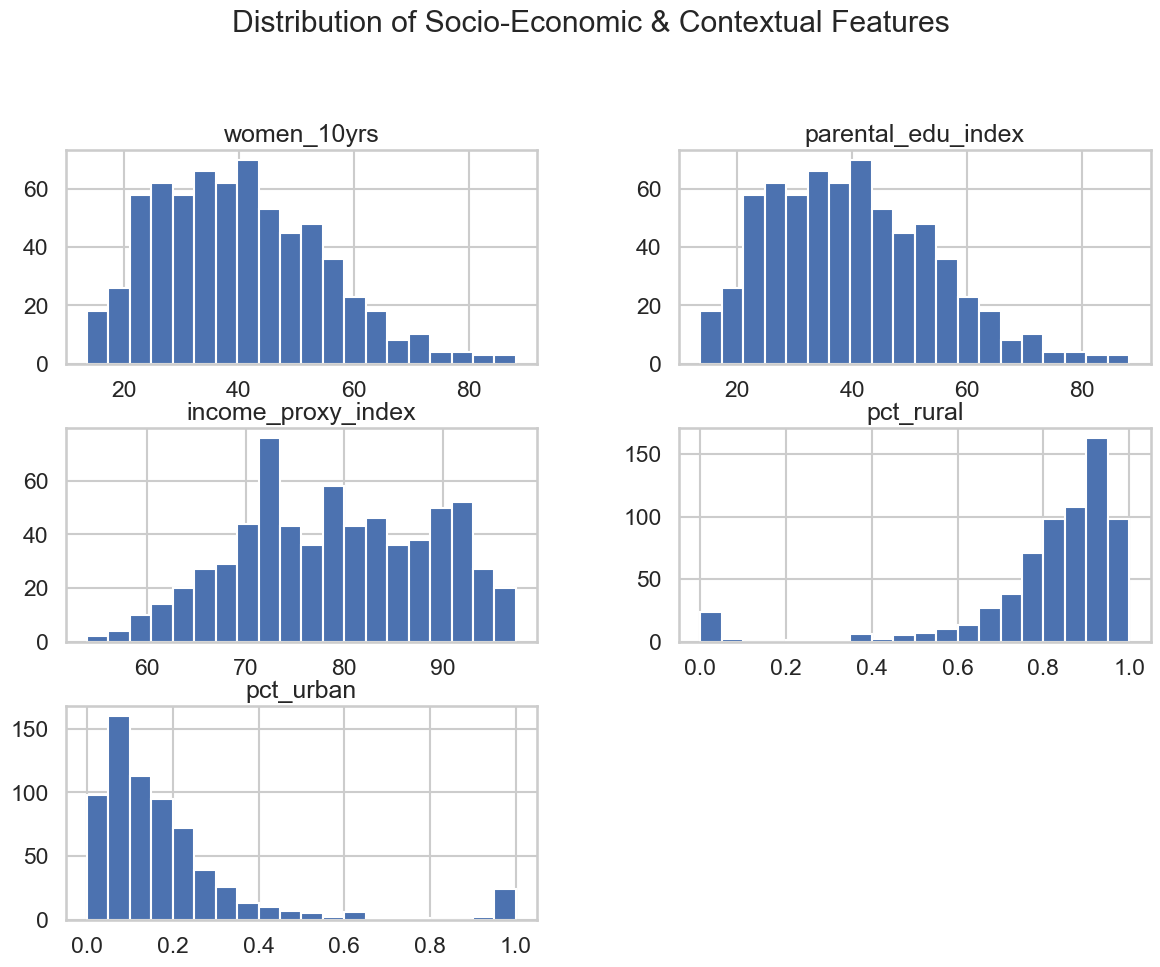

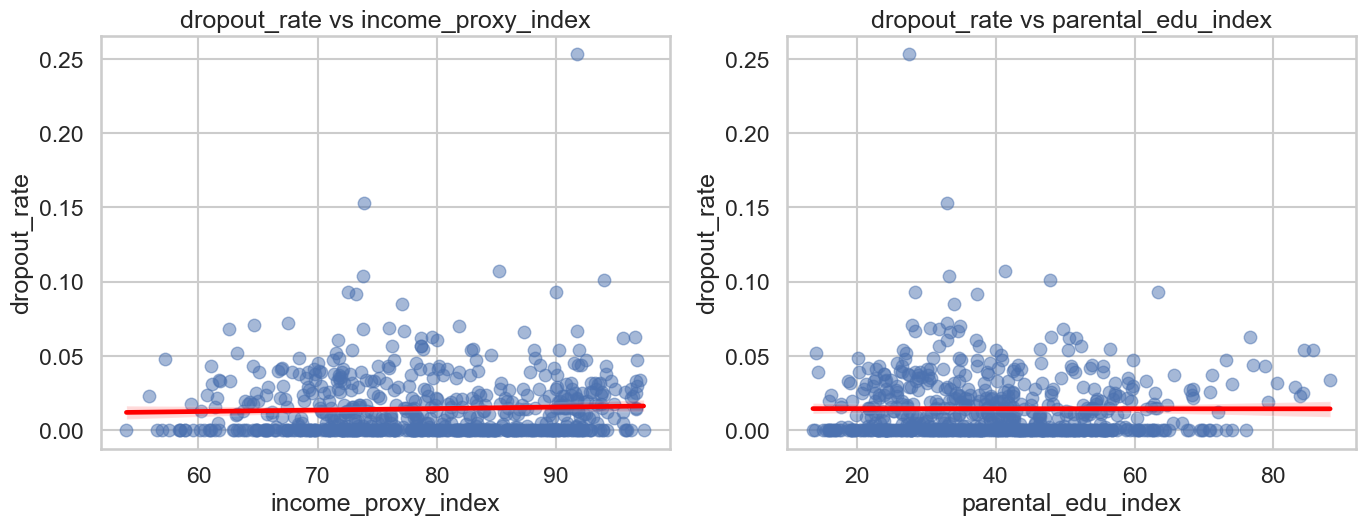

In [21]:
# ================================================================
# STEP 2: EDA - DISTRIBUTIONS & RELATIONSHIPS
# ================================================================
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk")

# Histograms for household features
model_df[features].hist(figsize=(14, 10), bins=20)
plt.suptitle("Distribution of Socio-Economic & Contextual Features", y=1.02)
plt.show()

# Dropout vs Key Predictors
key_pairs = [
    ('income_proxy_index', 'dropout_rate'),
    ('parental_edu_index', 'dropout_rate'),

]

plt.figure(figsize=(14, 10))
for i, (x, y) in enumerate(key_pairs, 1):
    plt.subplot(2, 2, i)
    sns.regplot(data=model_df, x=x, y=y, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f"{y} vs {x}")
plt.tight_layout()
plt.show()


In [22]:
# ================================================================
# STEP 4: STATISTICAL MODEL (OLS REGRESSION)
# ================================================================
import statsmodels.api as sm

X = model_df[features]
y = model_df[target]
X_const = sm.add_constant(X)

ols_model = sm.OLS(y, X_const).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:           dropout_rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.104
Date:                Mon, 10 Nov 2025   Prob (F-statistic):              0.347
Time:                        16:13:52   Log-Likelihood:                 1635.4
No. Observations:                 675   AIC:                            -3263.
Df Residuals:                     671   BIC:                            -3245.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0042      0

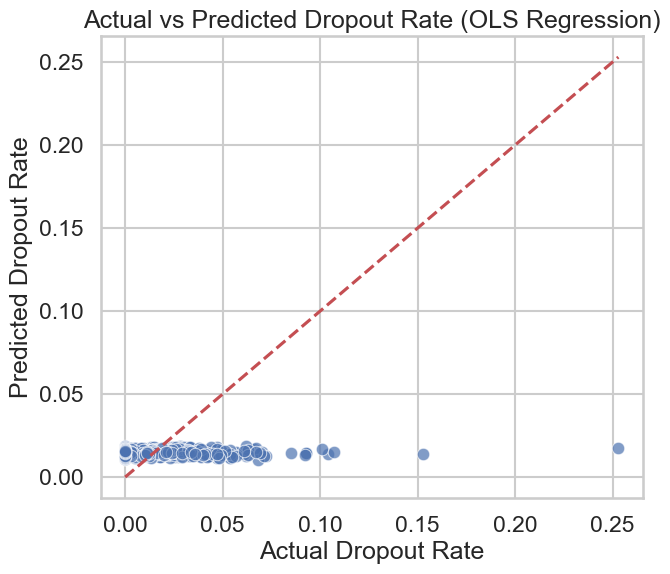

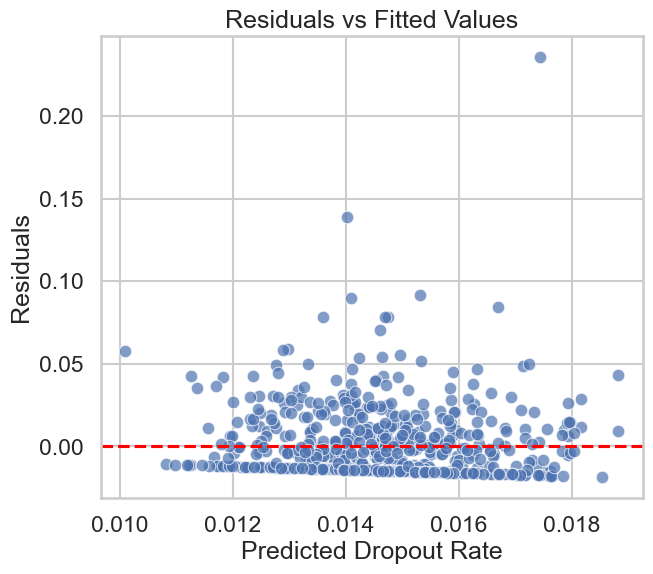

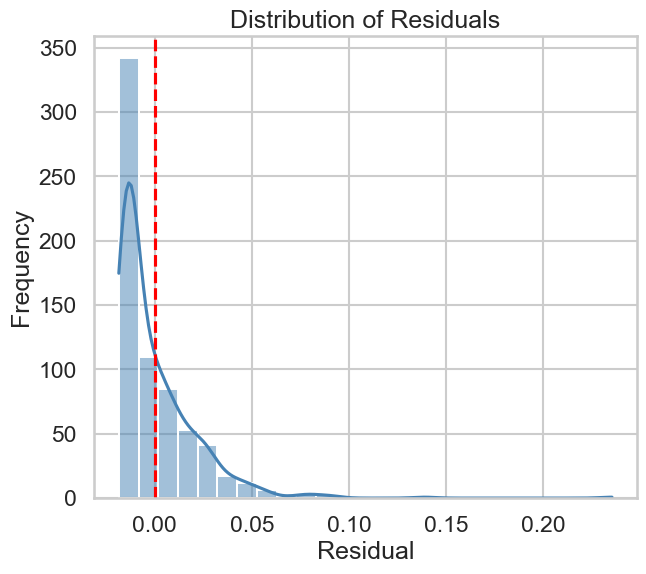

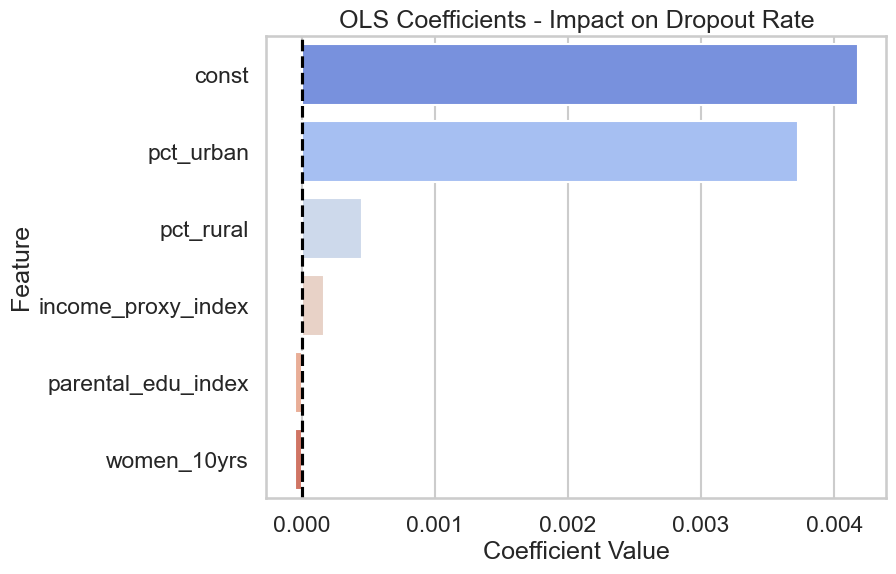

✅ Statistically significant predictors (p < 0.05):


,Feature,Coefficient,p_value


In [23]:
# ================================================================
# STEP 4B: REGRESSION VISUALIZATIONS (OLS DIAGNOSTICS + FIT)
# ================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1️⃣ Actual vs Predicted Plot ---
ols_preds = ols_model.predict(X_const)

plt.figure(figsize=(7,6))
sns.scatterplot(x=y, y=ols_preds, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Dropout Rate")
plt.ylabel("Predicted Dropout Rate")
plt.title("Actual vs Predicted Dropout Rate (OLS Regression)")
plt.show()

# --- 2️⃣ Residual Plot ---
residuals = y - ols_preds

plt.figure(figsize=(7,6))
sns.scatterplot(x=ols_preds, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Dropout Rate")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# --- 3️⃣ Distribution of Residuals (Normality Check) ---
plt.figure(figsize=(7,6))
sns.histplot(residuals, bins=25, kde=True, color="steelblue")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# --- 4️⃣ Coefficient Strength Plot ---
coeffs = pd.DataFrame({
    'Feature': X_const.columns,
    'Coefficient': ols_model.params,
    'p_value': ols_model.pvalues
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=coeffs, y='Feature', x='Coefficient', palette='coolwarm')
plt.title("OLS Coefficients - Impact on Dropout Rate")
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

# Highlight statistically significant predictors
sig = coeffs[coeffs['p_value'] < 0.05]
print("✅ Statistically significant predictors (p < 0.05):")
display(sig)


R² Score: -0.228


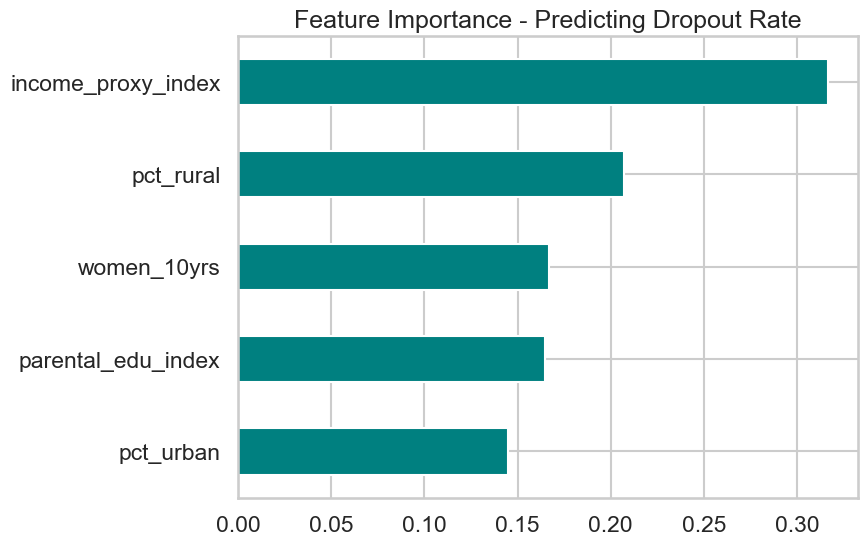

Top 5 most important predictors:


income_proxy_index   0.317
pct_rural            0.207
women_10yrs          0.167
parental_edu_index   0.165
pct_urban            0.145
dtype: float64

In [24]:
# ================================================================
# STEP 5: MACHINE LEARNING MODEL (RANDOM FOREST)
# ================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
rmse = mean_squared_error(y_test, y_pred) ** 0.5

# Feature importances
importances = pd.Series(rf.feature_importances_, index=features).sort_values()
plt.figure(figsize=(8,6))
importances.plot(kind='barh', color='teal')
plt.title("Feature Importance - Predicting Dropout Rate")
plt.show()

print("Top 5 most important predictors:")
display(importances.sort_values(ascending=False).head(5))


In [26]:
# ================================================================
# STEP 6: INTERPRETATION & POLICY INSIGHTS
# ================================================================
corrs = model_df.corr()[target].sort_values()
edu_corr = corrs['women_10yrs']
rural_corr = corrs['pct_rural']

print("📊 Correlation Summary:")
print(corrs)

print("\n🧠 Analytical Insights:")
if edu_corr < -0.3:
    print(f"➤ Dropout strongly declines with women's education (r={edu_corr:.2f}). Prioritize parental education and female literacy programs.")
if fuel_corr < -0.3:
    print(f"➤ Districts with better living standards (clean fuel, sanitation) have lower dropout (r={fuel_corr:.2f}). Invest in basic amenities.")
if rural_corr > 0.3:
    print(f"➤ Rural-heavy districts show higher dropout (r={rural_corr:.2f}). Focus on rural schooling and transport incentives.")

print("\n✅ Contextual Note: Variables like n_schools and pct_urban should be treated as supply-side controls, not primary SES indicators.")


📊 Correlation Summary:
pct_rural            -0.044
women_10yrs          -0.001
parental_edu_index   -0.001
pct_urban             0.044
income_proxy_index    0.045
dropout_rate          1.000
Name: dropout_rate, dtype: float64

🧠 Analytical Insights:

✅ Contextual Note: Variables like n_schools and pct_urban should be treated as supply-side controls, not primary SES indicators.


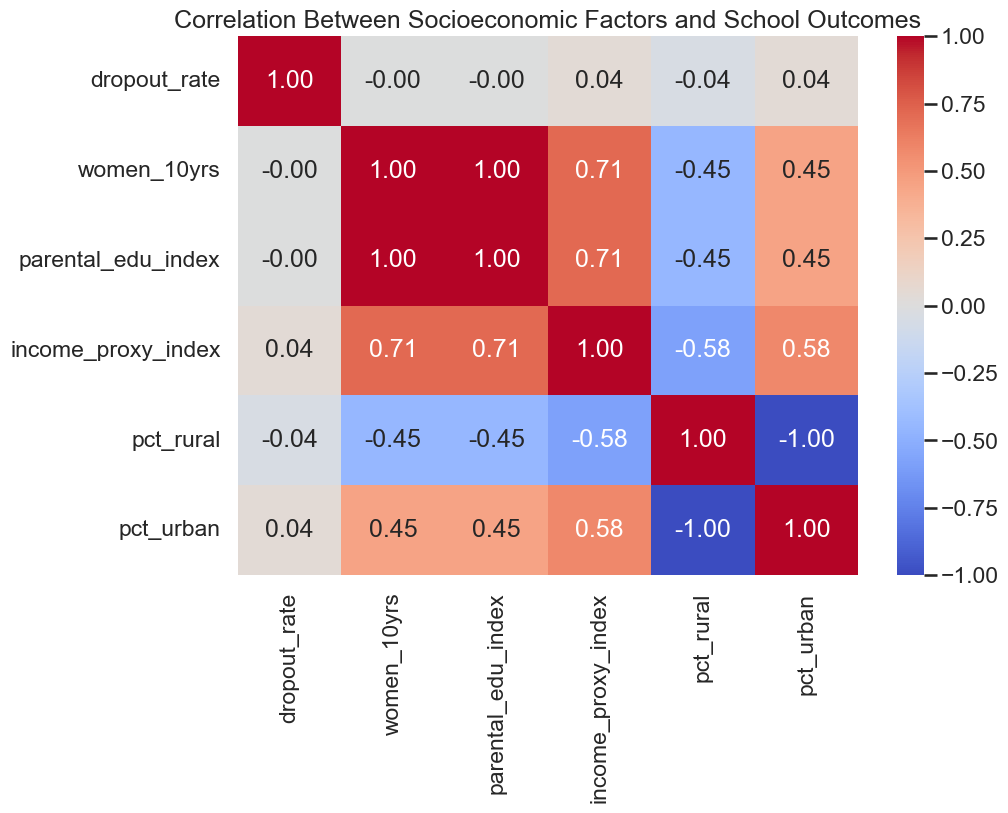

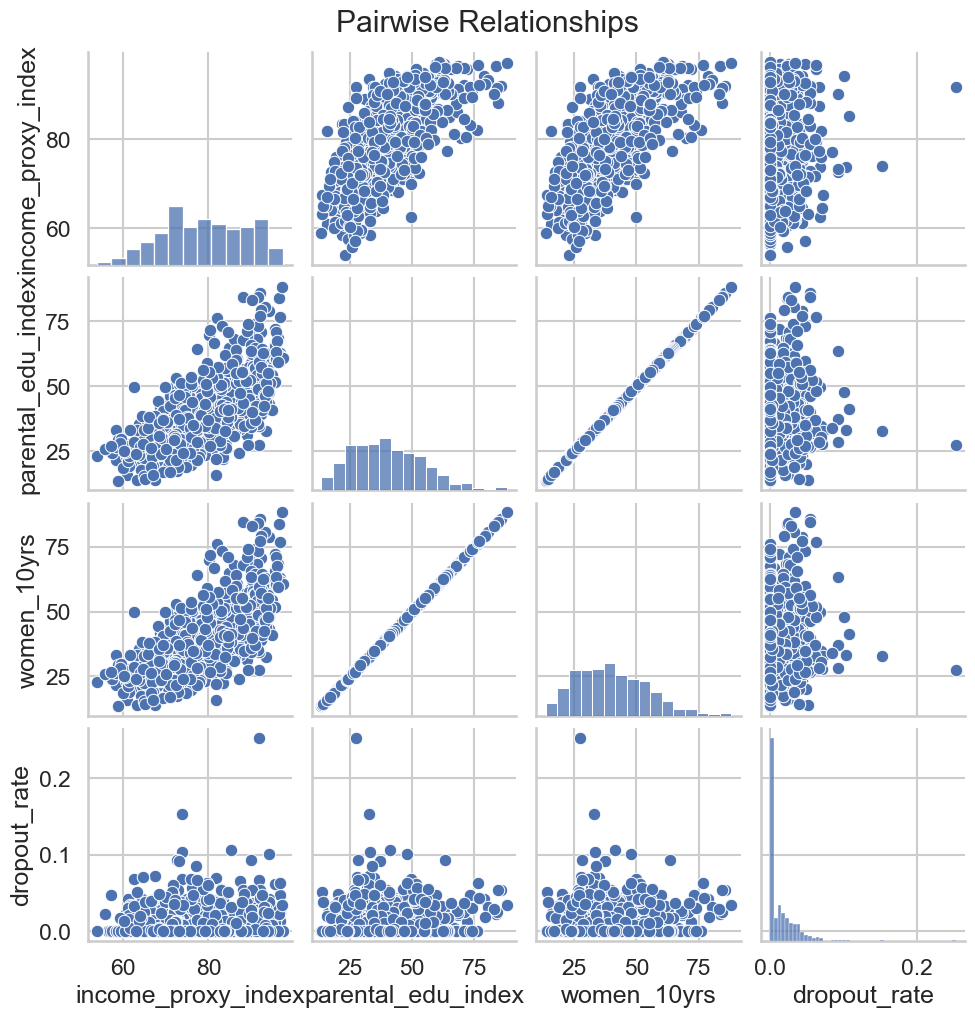

In [27]:
# Correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(model_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Socioeconomic Factors and School Outcomes")
plt.show()

# Pairplot for top correlated variables
sns.pairplot(model_df[['income_proxy_index', 'parental_edu_index','women_10yrs', 'dropout_rate']])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()
